In [1]:
# Install Category encoders
try:
    import category_encoders
except ImportError:
    !pip install category_encoders

# Install xgboost
try:
    import xgboost
except ImportError:
    !pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 7.7 MB/s eta 0:00:00


In [2]:
# Install required packages
try:
    import optuna
except ImportError:
    !pip install optuna

import optuna
from optuna.samplers import TPESampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.4 MB/s eta 0:00:00


In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import gc
import os
import json
from datetime import datetime

# XGBoost
import xgboost as xgb

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Scipy
from scipy.stats import randint, uniform, loguniform

# Category encoders
from category_encoders import TargetEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab
from google.colab import drive

print("All imports successful!")

All imports successful!


In [4]:
# Mount Drive
drive.mount('/content/drive')

# Configuration
CONFIG = {
    'data_path': "/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/Saved Data/final_df_v2.parquet",
    'output_dir': "/content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/",
    'sample_fraction': 0.10,  # For hyperparameter tuning
    'validation_days': 28,
    'random_state': 42
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)

print("Configuration loaded!")

Mounted at /content/drive
Configuration loaded!


In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [6]:
# Load data
print("Loading data...")
df = pd.read_parquet(CONFIG['data_path'])
df = reduce_mem_usage(df)
gc.collect()

print(f"Shape: {df.shape}, Memory: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")

# Define features
target = 'sales_count'
cols_to_drop = ['date', 'wm_yr_wk']
categorical_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
                       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
all_features = [col for col in df.columns if col != target and col not in cols_to_drop]

print(f"Features: {len(all_features)} ({len(categorical_features)} categorical)")

# Time-based split
df = df.sort_values(['item_id', 'store_id', 'date']).reset_index(drop=True)
split_date = df['date'].unique()[-CONFIG['validation_days']]

train_df = df[df['date'] < split_date].copy()
val_df = df[df['date'] >= split_date].copy()

print(f"Train: {len(train_df):,} | Val: {len(val_df):,}")

del df, split_date
gc.collect()

Loading data...
Memory usage decreased to 9820.56 Mb (0.0% reduction)
Shape: (59181090, 55), Memory: 9.59 GB
Features: 52 (9 categorical)
Train: 58,327,370 | Val: 853,720


0

In [7]:
# Sample time series for tuning (Stratified by Department)
unique_series = train_df[['item_id', 'store_id', 'dept_id']].drop_duplicates()

# Calculate fraction for stratified sampling
n_series = int(len(unique_series) * CONFIG['sample_fraction'])

# Perform stratified sampling based on 'dept_id'
sampled_series = unique_series.groupby('dept_id', group_keys=False).apply(
    lambda x: x.sample(frac=CONFIG['sample_fraction'], random_state=CONFIG['random_state'])
)

train_sample = pd.merge(train_df, sampled_series[['item_id', 'store_id']], on=['item_id', 'store_id'], how='inner')

print(f"Stratified Sampled: {len(train_sample):,} rows from {len(sampled_series):,} time series")

del unique_series, sampled_series
gc.collect()

/tmp/ipython-input-2175881509.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_series = unique_series.groupby('dept_id', group_keys=False).apply(
/tmp/ipython-input-2175881509.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_series = unique_series.groupby('dept_id', group_keys=False).apply(


Stratified Sampled: 5,832,737 rows from 3,049 time series


0

In [8]:
# Fit encoder on training sample
print("Encoding categorical features...")
encoder = TargetEncoder(cols=categorical_features, smoothing=1.0)

X_train_sample = encoder.fit_transform(train_sample[all_features], train_sample[target])
y_train_sample = train_sample[target].values

print(f"Encoded shape: {X_train_sample.shape}")

del train_sample
gc.collect()

Encoding categorical features...
Encoded shape: (5832737, 52)


0

In [9]:
# Define objectives to test
objectives_to_test = [
    'reg:tweedie',
]

# Base parameters (will be updated per objective)
def get_base_params(objective):
    params = {
        'device': 'cuda',
        'tree_method': 'hist',
        'objective': objective,
        'eval_metric': 'rmse',
        'random_state': CONFIG['random_state']
    }
    if objective == 'reg:tweedie':
        params['tweedie_variance_power'] = 1.5
    return params

print(f"Will test {len(objectives_to_test)} different objectives")

Will test 1 different objectives


In [10]:
def optuna_xgb_objective(trial, X, y, base_params, n_splits=3):
    """Optuna objective function for XGBoost"""

    # Optuna suggests parameters
    params = base_params.copy()
    params['n_estimators'] = trial.suggest_int('n_estimators', 200, 800)
    params['max_depth'] = trial.suggest_int('max_depth', 4, 12)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0)
    params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 10)
    params['gamma'] = trial.suggest_float('gamma', 0, 0.5)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 0, 1.0)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 0.1, 5.0)

    n_estimators = params.pop('n_estimators')

    # Time series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=n_estimators,
            evals=[(dval, 'val')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = model.predict(dval)
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        scores.append(rmse)

    return np.mean(scores)

print("Optuna objective function defined")

Optuna objective function defined


In [11]:
print("="*80)
print("OPTUNA HYPERPARAMETER OPTIMIZATION - MULTIPLE OBJECTIVES (GPU)")
print("="*80)

all_results = {}
best_overall_score = float('inf')
best_overall_params = None
best_overall_objective = None

for objective in objectives_to_test:
    print(f"\n{'='*80}")
    print(f"TESTING OBJECTIVE: {objective.upper()}")
    print(f"{'='*80}")

    base_params = get_base_params(objective)

    # Create Optuna study
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=CONFIG['random_state'])
    )

    start_time = datetime.now()

    # Optimize
    study.optimize(
        lambda trial: optuna_xgb_objective(
            trial, X_train_sample, y_train_sample, base_params, n_splits=3
        ),
        n_trials=20,  # Fewer trials needed with Optuna!
        show_progress_bar=True
    )

    duration = (datetime.now() - start_time).total_seconds()

    best_params = study.best_params
    best_params.update(base_params)  # Add back base params
    best_score = study.best_value

    print(f"\n{objective.upper()} completed in {duration/60:.1f} minutes")
    print(f"Best CV RMSE: {best_score:.4f}")
    print(f"Best parameters:")
    for k, v in sorted(best_params.items()):
        print(f"  {k}: {v}")

    # Store results
    all_results[objective] = {
        'best_score': best_score,
        'best_params': best_params,
        'study': study,
        'duration_minutes': duration/60
    }

    if best_score < best_overall_score:
        best_overall_score = best_score
        best_overall_params = best_params
        best_overall_objective = objective
        print(f"  ★ NEW OVERALL BEST! ★")

# Print comparison
print("\n" + "="*80)
print("FINAL COMPARISON ACROSS ALL OBJECTIVES")
print("="*80)
for objective, results in all_results.items():
    marker = "★" if objective == best_overall_objective else " "
    print(f"{marker} {objective:25s}: RMSE = {results['best_score']:.4f} ({results['duration_minutes']:.1f} min)")

print(f"\n{'='*80}")
print(f"BEST OVERALL: {best_overall_objective.upper()} with RMSE = {best_overall_score:.4f}")
print(f"{'='*80}")

# Save comparison
comparison_df = pd.DataFrame([
    {
        'objective': obj,
        'best_rmse': res['best_score'],
        'duration_minutes': res['duration_minutes']
    }
    for obj, res in all_results.items()
])
comparison_df.to_csv(
    os.path.join(CONFIG['output_dir'], 'objective_comparison.csv'),
    index=False
)

del X_train_sample, y_train_sample
gc.collect()

[I 2025-12-04 13:08:15,669] A new study created in memory with name: no-name-3055d0f7-110d-4b64-8a9e-1be489bf5909


OPTUNA HYPERPARAMETER OPTIMIZATION - MULTIPLE OBJECTIVES (GPU)

TESTING OBJECTIVE: REG:TWEEDIE


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-04 13:08:40,312] Trial 0 finished with value: 2.120638645260342 and parameters: {'n_estimators': 425, 'max_depth': 12, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'min_child_weight': 2, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 3.0454635575417233}. Best is trial 0 with value: 2.120638645260342.
[I 2025-12-04 13:08:56,391] Trial 1 finished with value: 2.0694625093659904 and parameters: {'n_estimators': 625, 'max_depth': 4, 'learning_rate': 0.2708160864249968, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'min_child_weight': 2, 'gamma': 0.09170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 2.6713065149979656}. Best is trial 1 with value: 2.0694625093659904.
[I 2025-12-04 13:09:15,856] Trial 2 finished with value: 2.055075483097957 and parameters: {'n_estimators': 459, 'max_depth': 6, 'learning_rate': 0.08012737503998542, 'subsample': 0.6

64

In [12]:
print("="*80)
print("BEST PARAMETERS")
print("="*80)

print(f"\nBest objective: {best_overall_objective}")
print(f"Best CV RMSE: {best_overall_score:.4f}")
print("\nBest parameters:")
for k, v in sorted(best_overall_params.items()):
    print(f"  {k}: {v}")

# Save best parameters
with open(os.path.join(CONFIG['output_dir'], 'best_params.json'), 'w') as f:
    json.dump(best_overall_params, f, indent=4)

# Save all results for comparison
with open(os.path.join(CONFIG['output_dir'], 'all_objectives_results.json'), 'w') as f:
    json.dump({
        obj: {
            'best_score': float(res['best_score']),
            'best_params': res['best_params'],
            'duration_minutes': res['duration_minutes']
        }
        for obj, res in all_results.items()
    }, f, indent=4)

print(f"\nAll results saved to: {CONFIG['output_dir']}")

BEST PARAMETERS

Best objective: reg:tweedie
Best CV RMSE: 2.0431

Best parameters:
  colsample_bytree: 0.9859519972079405
  device: cuda
  eval_metric: rmse
  gamma: 0.07577733821816761
  learning_rate: 0.09876765195838019
  max_depth: 7
  min_child_weight: 3
  n_estimators: 364
  objective: reg:tweedie
  random_state: 42
  reg_alpha: 0.4181540822820741
  reg_lambda: 3.1606830380618893
  subsample: 0.8950939276486971
  tree_method: hist
  tweedie_variance_power: 1.5

All results saved to: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/


In [13]:
print("="*80)
print("TRAINING ON FULL DATA")
print("="*80)

# Load saved best parameters
params_path = os.path.join(CONFIG['output_dir'], 'best_params.json')
print(f"Loading parameters from: {params_path}")

with open(params_path, 'r') as f:
    best_params = json.load(f)

print("Loaded parameters:")
for k, v in sorted(best_params.items()):
    print(f"  {k}: {v}")

# Encode full training data
print("\nEncoding full training data...")
encoder_full = TargetEncoder(
    cols=categorical_features,
    smoothing=best_params.get('smoothing', 1.0)
)
X_train_full = encoder_full.fit_transform(train_df[all_features], train_df[target])
y_train_full = train_df[target].values

# Encode validation data
X_val = encoder_full.transform(val_df[all_features])
y_val = val_df[target].values

# Create DMatrix
dtrain = xgb.DMatrix(X_train_full, label=y_train_full)
dval = xgb.DMatrix(X_val, label=y_val)

print(f"Training: {X_train_full.shape} | Validation: {X_val.shape}")

# Prepare training params (separate n_estimators)
train_params = {k: v for k, v in best_params.items() if k != 'n_estimators'}
n_rounds = best_params['n_estimators']

print(f"\nTraining with {n_rounds} boosting rounds...")

# Train
final_model = xgb.train(
    train_params,
    dtrain,
    num_boost_round=n_rounds,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=20
)

print("\nTraining complete!")

del train_df, dtrain, X_train_full, y_train_full
gc.collect()

TRAINING ON FULL DATA
Loading parameters from: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/best_params.json
Loaded parameters:
  colsample_bytree: 0.9859519972079405
  device: cuda
  eval_metric: rmse
  gamma: 0.07577733821816761
  learning_rate: 0.09876765195838019
  max_depth: 7
  min_child_weight: 3
  n_estimators: 364
  objective: reg:tweedie
  random_state: 42
  reg_alpha: 0.4181540822820741
  reg_lambda: 3.1606830380618893
  subsample: 0.8950939276486971
  tree_method: hist
  tweedie_variance_power: 1.5

Encoding full training data...
Training: (58327370, 52) | Validation: (853720, 52)

Training with 364 boosting rounds...
[0]	train-rmse:3.82037	val-rmse:3.60669
[20]	train-rmse:2.67058	val-rmse:2.43077
[40]	train-rmse:2.10459	val-rmse:1.99788
[60]	train-rmse:2.05085	val-rmse:1.96942
[80]	train-rmse:2.03326	val-rmse:1.96238
[100]	train-rmse:2.02098	val-rmse:1.95812
[120]	train-rmse:2.01341	val-rmse:1.95565
[140]	train-rmse:2.00760	val-rmse:1

28

In [14]:
print("="*80)
print("VALIDATION RESULTS")
print("="*80)

# Predictions
val_pred = final_model.predict(dval)

# Metrics
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
mae = mean_absolute_error(y_val, val_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# Baseline comparison
naive_pred = val_df.groupby(['item_id', 'store_id'])[target].transform('mean').fillna(0)
baseline_rmse = np.sqrt(mean_squared_error(y_val, naive_pred))

print(f"\nBaseline RMSE: {baseline_rmse:.4f}")
print(f"Improvement: {(1 - rmse/baseline_rmse)*100:.1f}%")

del naive_pred
gc.collect()

VALIDATION RESULTS
RMSE: 1.9440
MAE:  0.9850

Baseline RMSE: 1.9818
Improvement: 1.9%


/tmp/ipython-input-3054170391.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  naive_pred = val_df.groupby(['item_id', 'store_id'])[target].transform('mean').fillna(0)


19

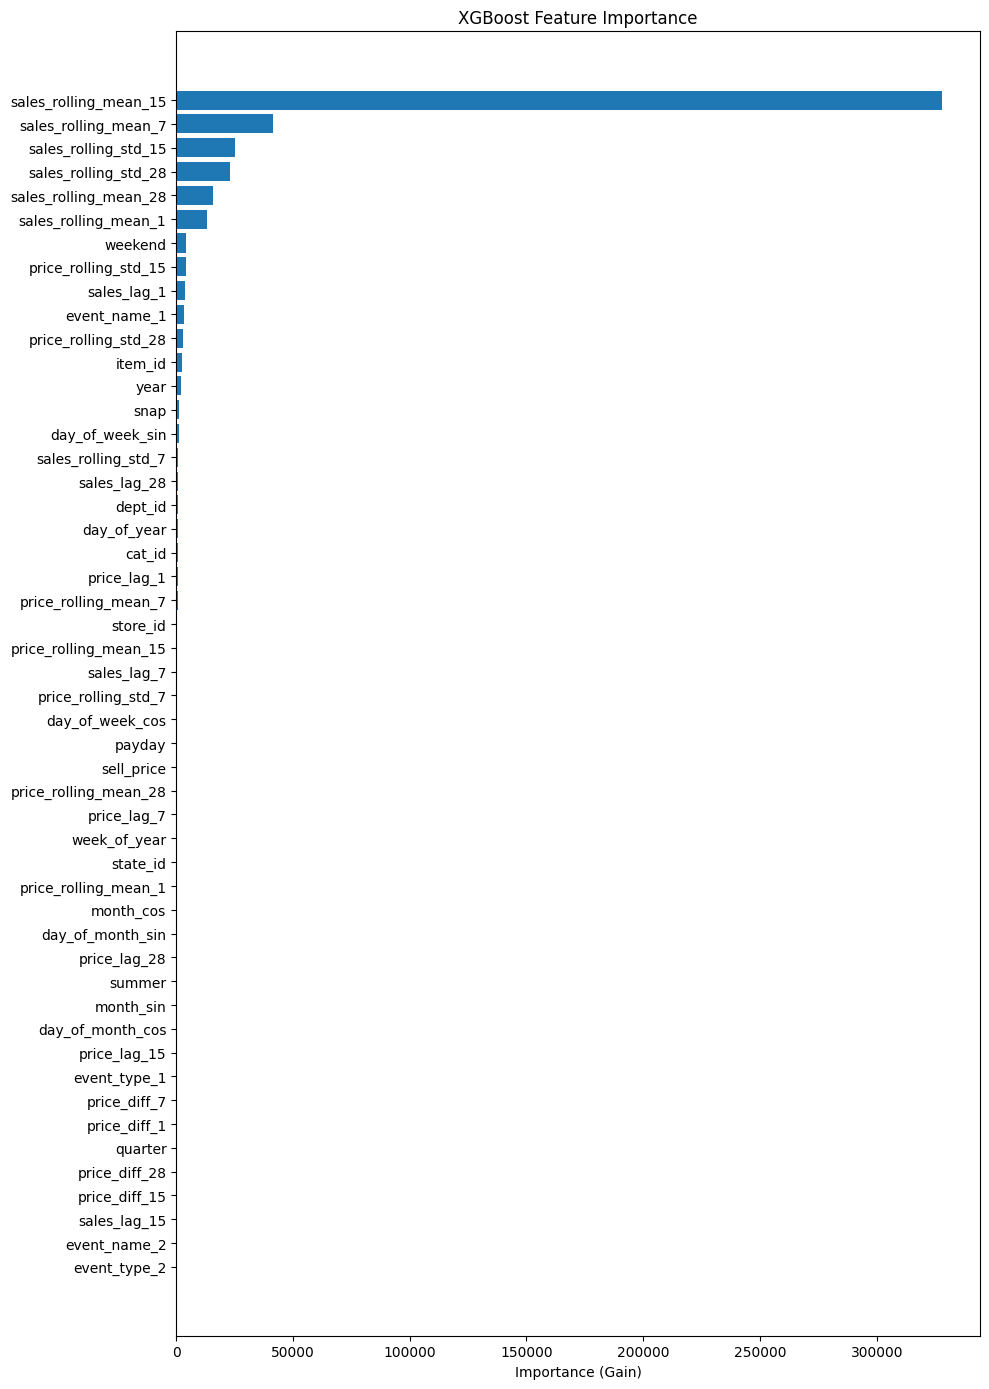

In [15]:
# Get feature importance
importance = final_model.get_score(importance_type='gain')
feat_imp = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False)


# Plot
plt.figure(figsize=(10, 14))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.xlabel('Importance (Gain)')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save
feat_imp.to_csv(os.path.join(CONFIG['output_dir'], 'feature_importance.csv'), index=False)

/tmp/ipython-input-3677952295.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_cat = val_df_analysis.groupby('cat_id').agg({


Error by Category:
           residual  abs_error  sales_count
cat_id                                     
FOODS         0.048      1.256        2.069
HOBBIES       0.022      0.739        0.732
HOUSEHOLD     0.022      0.745        0.967


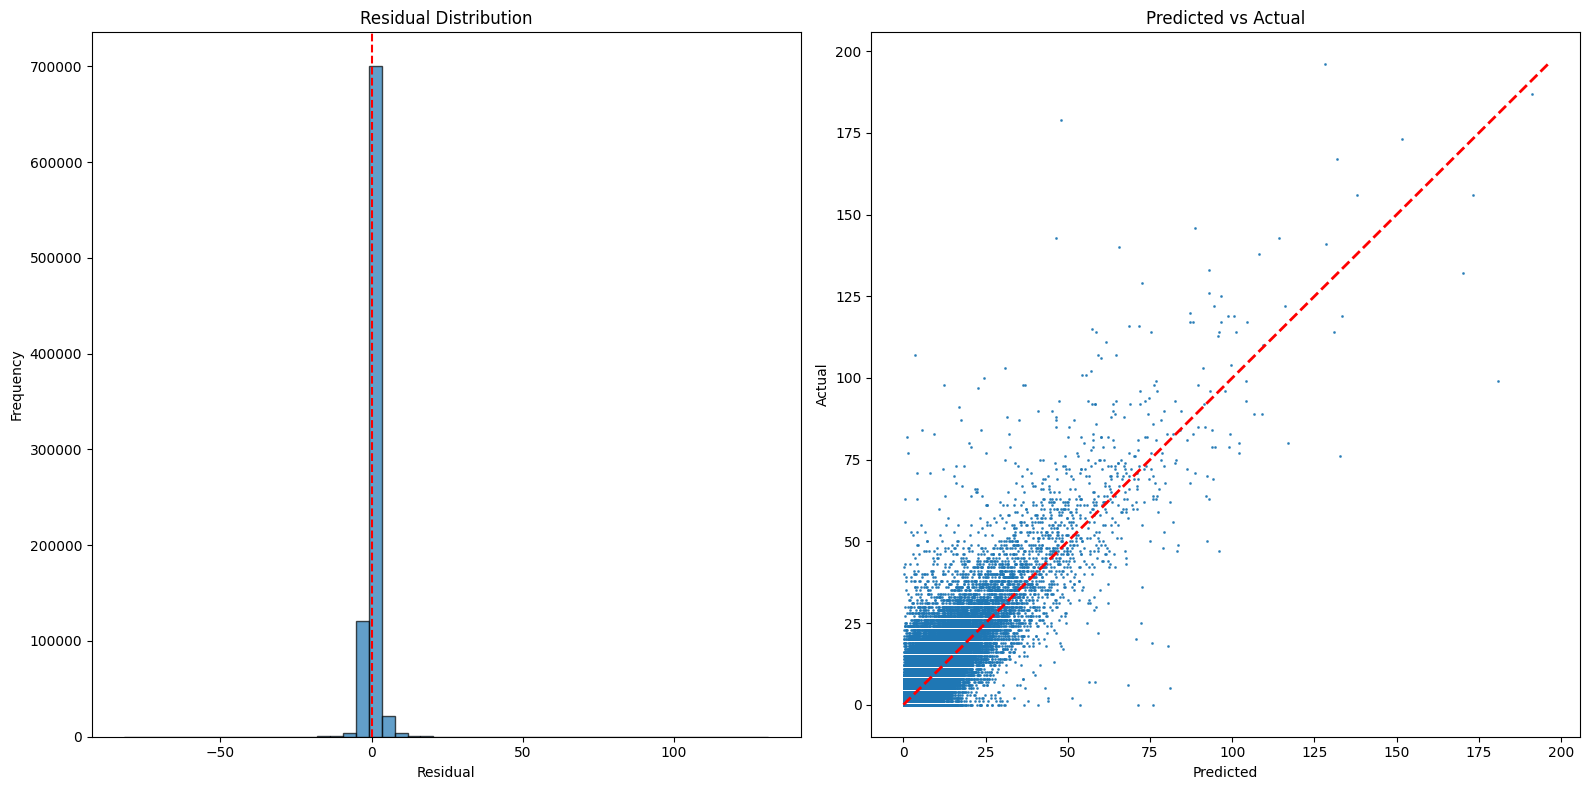

9991

In [16]:
# Residual analysis
residuals = y_val - val_pred
val_df_analysis = val_df.copy()
val_df_analysis['prediction'] = val_pred
val_df_analysis['residual'] = residuals
val_df_analysis['abs_error'] = np.abs(residuals)

# Error by category
error_by_cat = val_df_analysis.groupby('cat_id').agg({
    'residual': 'mean',
    'abs_error': 'mean',
    target: 'mean'
}).round(3)

print("Error by Category:")
print(error_by_cat)

# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residual Distribution')
axes[0].axvline(0, color='red', linestyle='--')

axes[1].scatter(val_pred, y_val, alpha=0.8, s=1)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Predicted vs Actual')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'error_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

del val_df_analysis
gc.collect()

In [17]:
# Save model
model_path = os.path.join(CONFIG['output_dir'], 'xgb_model_final.json')
final_model.save_model(model_path)

# Save encoder
import pickle
encoder_path = os.path.join(CONFIG['output_dir'], 'encoder_final.pkl')
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder_full, f)

# Save results
results = {
    'val_rmse': float(rmse),
    'val_mae': float(mae),
    'baseline_rmse': float(baseline_rmse),
    'improvement_pct': float((1 - rmse/baseline_rmse)*100),
    'best_params': best_params,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(os.path.join(CONFIG['output_dir'], 'results_final.json'), 'w') as f:
    json.dump(results, f, indent=4)

print(f"Model saved: {model_path}")
print(f"Encoder saved: {encoder_path}")
print(f"Results saved to: {CONFIG['output_dir']}")

Model saved: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/xgb_model_final.json
Encoder saved: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/encoder_final.pkl
Results saved to: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/


In [18]:
print("="*80)
print("TRAINING COMPLETE!")
print("="*80)
print(f"""
Device: A100 GPU
Validation RMSE: {rmse:.4f}
Improvement: {(1 - rmse/baseline_rmse)*100:.1f}%
All files saved to: {CONFIG['output_dir']}
""")

TRAINING COMPLETE!

Device: A100 GPU
Validation RMSE: 1.9440
Improvement: 1.9%
All files saved to: /content/drive/MyDrive/SU Works/CPSC_5305_Intro_to_DS/Rizvans Works/XGBoost_Results/

